<a href="https://colab.research.google.com/github/sharon-kurant/Domain-Specific-Article-Classification-using-BERT-Based-Models/blob/main/Domain_Specific_Article_Classification_using_BERT_Based_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

- **Dataset**: The data consists of some scientific articles that includes **title** and its **abstract**. The objective is to predict which category the article is in based on these two unstructured texts. There are six categories, and each article can belong to more than one category.
- **Modeling**: We use SciBERT, a variant of BERT model, to obtain embedding for the title and abstract. We use **huggingface** library for the BERT model. We concateate the embedding and feed to MLP layer to predict 1/0 for each subject **independently**.
- **Result**: Obtain substantial results on accuracy and F1 score metrics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import logging, os
import pandas as pd
from sklearn import metrics
import re 
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
DATA_PATH = '/content/drive/MyDrive/NLP_Final_Project/data'
TEST_PATH = DATA_PATH + os.sep + 'test.csv'
TRAIN_PATH = DATA_PATH + os.sep + 'train.csv'
DATA_PATH_MORE = DATA_PATH + '_more_labels'

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle
from transformers import AutoTokenizer, AutoModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from torch import cuda, nn
device = 'cuda' if cuda.is_available() else 'cpu'
%matplotlib inline

# Load Dataset

In [ ]:
# use columns 1-6 (removes ID, and quantitaive biology & quantitative finance)
df = pd.read_csv(DATA_PATH_MORE + '/train.csv', usecols = [i for i in range(1,7)])
df['TEXT'] = pd.Series([" ".join(sentence.split(" ")[:20]) for sentence in df['TITLE']]) + " " + df['ABSTRACT']

In [ ]:
df = df[df.iloc[:,2:6].sum(axis=1)>0]

In [ ]:
df

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,TEXT
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,Rotation Invariance Neural Network Rotation ...
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,Spherical polyharmonics and Poisson kernels fo...
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,A finite element approximation for the stochas...
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,Comparative study of Discrete Wavelet Transfor...
...,...,...,...,...,...,...,...
20967,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,Contemporary machine learning: a guide for pra...
20968,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,Uniform diamond coatings on WC-Co hard alloy c...
20969,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,Analysing Soccer Games with Clustering and Con...
20970,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,On the Efficient Simulation of the Left-Tail o...


In [ ]:
df.iloc[:,2:-1].sum(axis = 0)

Computer Science    8594
Physics             6013
Mathematics         5618
Statistics          5206
dtype: int64

In [ ]:
print ("total rows: ", len(df))

total rows:  20316


In [ ]:
df.isnull().sum()

TITLE               0
ABSTRACT            0
Computer Science    0
Physics             0
Mathematics         0
Statistics          0
TEXT                0
dtype: int64

Apparently, all data is clean. No record 404. :D

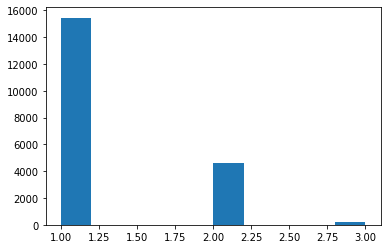

In [ ]:
subject_df = df.drop(['TITLE', 'ABSTRACT', 'TEXT'], axis=1)

subject_per_entry = subject_df.sum(axis=1)
subject_per_entry.hist(grid=False)
plt.show()

Most articles are only in one category. However, there are also around 6,000 articles that consist of multiple categories.

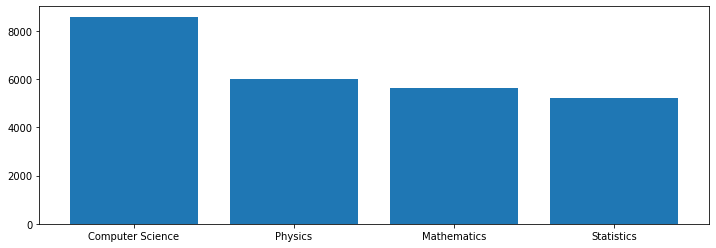

In [ ]:
column_names = subject_df.columns
X_axis = range(len(column_names))

plt.figure(figsize=(12, 4))
plt.bar(X_axis, df.drop(['TITLE', 'ABSTRACT', 'TEXT'], axis=1).sum())
plt.xticks(X_axis, column_names)

plt.show()

The subjects are imbalanced. CS has almost double the amount of statistics.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

In [ ]:
title_lens = [ len(tokenizer.tokenize(x)) for x in df['TITLE'] ]
abstract_lens = [ len(tokenizer.tokenize(x)) for x in df['ABSTRACT'] ]

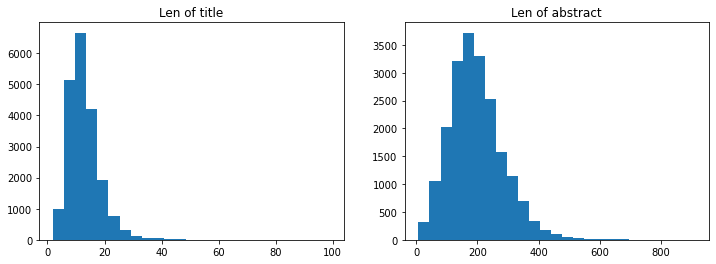

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(title_lens, bins=25)
plt.title('Len of title')

plt.subplot(1, 2, 2)
plt.hist(abstract_lens, bins=25)
plt.title('Len of abstract')

plt.show()

In [ ]:
print(f'Title length median = {np.median(title_lens)}')
print(f'Title length mean = {np.mean(title_lens):.1f}\n')

print(f'Abstract length median = {np.median(abstract_lens)}')
print(f'Abstract length mean = {np.mean(abstract_lens):.1f}')

Title length median = 12.0
Title length mean = 12.8

Abstract length median = 186.0
Abstract length mean = 196.5


# Modeling

**Token Lengths**:
- In average, the title has length around 12 tokens.
- The abstract, on the other hand, has around 200 tokens. It can goes up to 700 tokens, but there aren't much.

# Preprocess Dataset Title + Abstract

In [ ]:
df['labels'] = df[column_names].values.tolist()
new_df = df[['TEXT', 'labels']].copy()
new_df.head()

,TEXT,labels
0,Reconstructing Subject-Specific Effect Maps ...,"[1, 0, 0, 0]"
1,Rotation Invariance Neural Network Rotation ...,"[1, 0, 0, 0]"
2,Spherical polyharmonics and Poisson kernels fo...,"[0, 0, 1, 0]"
3,A finite element approximation for the stochas...,"[0, 0, 1, 0]"
4,Comparative study of Discrete Wavelet Transfor...,"[1, 0, 0, 1]"


In [ ]:
def clean_text(txt):
    """Perform some basic cleaning of the text."""
    return re.sub("[^A-Za-z0-9.,;:!-?]+", ' ', str(txt))

In [ ]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len, new_data=False, column = 'TITLE'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.text = dataframe[column]
        self.new_data = new_data
        self.max_len = max_len
        
        # if not new_data:
        self.targets = self.data.labels

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        text = clean_text(text)

        inputs = self.tokenizer(
            text, 
            truncation=True, 
            padding='max_length' if self.new_data else False,
            max_length=self.max_len, 
            return_tensors="pt"
        )
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        
        if not self.new_data:
            labels = torch.tensor(self.targets[index], dtype=torch.float)
            return inputs, labels

        return inputs

In [ ]:
def dynamic_collate(data, tokenizer = None):
    """Custom data collator for dynamic padding."""
    inputs = [d for d,l in data]
    labels = torch.stack([l for d,l in data], dim=0)
    inputs = tokenizer.pad(inputs, return_tensors='pt')
    return inputs, labels

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, bert_model, fine_tuning=True, num_classes = 4):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model)
        if not fine_tuning:
          for param in self.bert.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(768, num_classes)
        )
        print(f'{num_classes=}')

    def forward(self, inputs):
        bert_output = self.bert(**inputs)
        hidden_state = bert_output.last_hidden_state
        pooled_out = hidden_state[:, 0]
        logits = self.classifier(pooled_out)
        return logits


In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    """An accuracy metric for multi-label problems."""
    if sigmoid: 
        inp = inp.sigmoid()
    return ((inp > thresh) == targ.bool()).float().mean().cpu().detach().numpy()

In [ ]:
def f1_multi(inp, targ, thresh=0.5, sigmoid=True, average = 'micro'):
    """An accuracy metric for multi-label problems."""
    if sigmoid: 
        inp = inp.sigmoid()
    out = (inp > thresh).float().cpu().detach().numpy()
    return metrics.f1_score(targ.float().cpu().detach().numpy(), out, average = average, zero_division = 1)

In [ ]:
def train_one_epoch(train_loader, model, loss_func, optimizer, device):
    """Train model over one epoch."""
    model.train()
    size = len(train_loader.dataset)  # Train set size
    losses = []
    accuracies = []
    
    for i, (data, targets) in enumerate(train_loader):
        # Put inputs and target on device
        data = {k: v.to(device) for k, v in data.items()}
        targets = targets.to(device)
        
        outputs = model(data).to(device)
        
        loss = loss_func(outputs, targets)
        accuracy = accuracy_multi(outputs, targets)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("  Training metrics:")
    print(f"\tLoss: {np.mean(losses):>4f}\tAcc: {np.mean(accuracies):>4f}")
    return np.mean(losses), np.mean(accuracies)

In [ ]:
def validate_one_epoch(val_loader, model, loss_func, device):
    """Validate model over one epoch."""
    model.eval()
    num_batches = len(val_loader)
    
    valid_loss, acc_multi, f1_multi_micro, f1_multi_macro = 0, 0, 0, 0
    losses = []
    accuracies = []
    with torch.no_grad():
        for _, (data, targets) in enumerate(val_loader):
            data = {k: v.to(device) for k, v in data.items()}
            targets = targets.to(device)

            outputs = model(data)
            
            valid_loss += loss_func(outputs, targets).item()
            acc_multi += accuracy_multi(outputs, targets)

            losses.append(loss_func(outputs, targets).item())
            accuracies.append(accuracy_multi(outputs, targets))

            f1_multi_micro += f1_multi(outputs, targets, average='micro')
            f1_multi_macro += f1_multi(outputs, targets, average='macro')
            
    valid_loss /= num_batches  # Avg. loss
    acc_multi /= num_batches   # Avg. acc. multi
    f1_multi_micro /= num_batches   # Avg. f1 micro multi
    f1_multi_macro /= num_batches   # Avg. f1 macro multi
    print("  Validation metrics:")
    print(f"\tAvg. valid. loss: {valid_loss:>4f}, Acc. multi: {acc_multi:>4f}\n\tAvg. F1 Score (Micro) = {f1_multi_micro:>4f}, Avg. F1 Score (Macro) = {f1_multi_macro:>4f}")
    return valid_loss, acc_multi


In [ ]:
def plot_train_val_test(train_losses,train_accuracies,validation_losses,validation_accuracies):

  plt.plot(train_losses)
  plt.plot(validation_losses)
  plt.grid()
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('batches')
  plt.legend(['train','validation'])
  plt.show()

  plt.plot(train_accuracies)
  plt.plot(validation_accuracies)
  plt.grid()
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train','validation'])
  plt.show()


In [ ]:
def set_hyperparameters(max_len = 300, batch_size = 32, lr = 1e-05, bert_model = 'scibert'):
  if bert_model == 'scibert':
    bert_model = 'allenai/scibert_scivocab_uncased'
  else:
    bert_model = 'bert-base-uncased'

  device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
  hyperparameters_keys = ['bert_model', 'max_len', 'batch_size', 'lr', 'device']
  hyperparameters_values = [bert_model, max_len, batch_size, lr, device]
  
  return {key: value for key, value in zip(hyperparameters_keys,hyperparameters_values)}

In [ ]:
def train_val_test_df_split(df: pd.DataFrame, frac=0.7):
  train_df = df.sample(frac=frac, random_state=123)
  val_df = df.drop(train_df.index)
  train_df = train_df.reset_index(drop=True)

  test_df = val_df.sample(frac=0.4, random_state=123)
  val_df = val_df.drop(test_df.index).reset_index(drop=True)
  test_df = test_df.reset_index(drop=True)

  print("Original Dataset: {}".format(df.shape))
  print("Training Dataset: {}".format(train_df.shape))
  print("Validation Dataset: {}".format(val_df.shape))
  print("Test Dataset: {}".format(test_df.shape))

  return train_df, val_df, test_df

In [ ]:
def prepare_training(df: pd.DataFrame, fine_tuning = True, max_len = 300, batch_size = 32, lr = 1e-05, bert_model = 'scibert', column = 'TITLE', num_classes=4):

  # available hyperparameters keys: bert_model, max_len, batch_size, epochs, lr, device
  hyperparameters = set_hyperparameters(max_len, batch_size, lr, bert_model)
  print("Device:", hyperparameters['device'])
  print("Bert:",hyperparameters['bert_model'])

  tokenizer = BertTokenizer.from_pretrained(hyperparameters['bert_model'], do_lower_case=True)

  train_df, val_df, test_df = train_val_test_df_split(df)

  print(f'Training on {column} column with {max_len} token max')
  train_set = MultiLabelDataset(train_df, tokenizer, hyperparameters['max_len'], column = column)
  val_set = MultiLabelDataset(val_df, tokenizer, hyperparameters['max_len'], column = column)
  test_set = MultiLabelDataset(test_df, tokenizer, hyperparameters['max_len'], column = column)

  train_params = {'batch_size': hyperparameters['batch_size'],
                'shuffle': True,
                'num_workers': 2, 
                'collate_fn': lambda batch: dynamic_collate(batch, tokenizer)}

  val_params = {'batch_size': hyperparameters['batch_size'],
                'shuffle': True,
                'num_workers': 2, 
                'collate_fn': lambda batch: dynamic_collate(batch, tokenizer)}
  
  test_params = {'batch_size': hyperparameters['batch_size'],
                'shuffle': False,
                'num_workers': 2, 
                'collate_fn': lambda batch: dynamic_collate(batch, tokenizer)}

  train_loader = DataLoader(train_set, **train_params)
  val_loader = DataLoader(val_set, **val_params)
  test_loader = DataLoader(test_set, **test_params)

  model = TransformerModel(hyperparameters['bert_model'], fine_tuning, num_classes=num_classes)
  model.to(hyperparameters['device'])

  if fine_tuning:
    print('fine-tuning enabled, will fine-tune Bert model!')
  else:
    print('fine-tuning disabled, only training the head!')

  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  print(f"Trainable params: {round(trainable_params/1e6, 1)} M")

  optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])
  
  targs = torch.tensor(train_set.targets.tolist())
  print(targs)
  
  num_positives = torch.sum(targs, dim=0)
  print(f'{num_positives=}')
  num_negatives = len(targs) - num_positives
  print(f'{num_negatives=}')
  pos_weight  = num_negatives / num_positives
  pos_weight = pos_weight.to(hyperparameters['device'])
  print(f'{pos_weight=}')
  loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)

  return model, train_loader, val_loader, optimizer, loss_func, lr_sched, hyperparameters, test_loader

In [ ]:
def test(test_loader, model, device):
    print('testing..........')
    
    model.eval()
    num_batches = len(test_loader)
    predictions = []
    targs = []

    acc_multi, f1_multi_micro, f1_multi_macro = 0, 0, 0
    accuracies = []
    with torch.no_grad():
        for _, (data, targets) in enumerate(test_loader):
            data = {k: v.to(device) for k, v in data.items()}
            targets = targets.to(device)

            outputs = model(data)
            predictions.append(outputs.sigmoid()>0.5)
            targs.append(targets)
            acc_multi += accuracy_multi(outputs, targets)

            accuracies.append(accuracy_multi(outputs, targets))

            f1_multi_micro += f1_multi(outputs, targets, average='micro')
            f1_multi_macro += f1_multi(outputs, targets, average='macro')

    targs = torch.cat(targs).int()
    predictions = torch.cat(predictions).int()
    acc_multi /= num_batches   # Avg. acc. multi
    f1_multi_micro /= num_batches   # Avg. f1 micro multi
    f1_multi_macro /= num_batches   # Avg. f1 macro multi
    print("  Test metrics:")
    print(f"\tAcc. multi: {acc_multi:>4f}\n\tAvg. F1 Score (Micro) = {f1_multi_micro:>4f}, Avg. F1 Score (Macro) = {f1_multi_macro:>4f}")
    return predictions, targs

In [ ]:
def train_model(df: pd.DataFrame, fine_tuning = True, bert_model = 'scibert', epochs = 3, max_len = 300, column = 'TITLE', num_classes=4):
  model, train_loader, val_loader, optimizer, loss_func, lr_sched, hyperparameters, test_loader = prepare_training(df, fine_tuning=fine_tuning, bert_model=bert_model, max_len = max_len, column = column, num_classes=num_classes, batch_size=16)
  
  # num_train_steps = epochs * len(train_loader)
  train_losses, train_accuracies = [], []
  validation_losses, validation_accuracies = [], []

  for epoch in range(epochs):
      print(f"\nEpoch {epoch+1} (lr = {lr_sched.get_last_lr()[0]:.2e})\n-------------------------------")
      train_loss, train_accuracy = train_one_epoch(train_loader, model, loss_func, optimizer, hyperparameters['device'])
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      validation_loss, validation_accuracy = validate_one_epoch(val_loader, model, loss_func, hyperparameters['device'])
      validation_losses.append(validation_loss)
      validation_accuracies.append(validation_accuracy)
      lr_sched.step()
  predictions = test(test_loader, model, hyperparameters['device'])
  plot_train_val_test(train_losses, train_accuracies,validation_losses, validation_accuracies)

  return predictions

# Model performance

In [ ]:
bools_berts = [[True, False], ['scibert', 'base'], [('TITLE', 20), ('ABSTRACT', 250), ('TEXT', 270)]]

bools_berts = sorted(list(itertools.product(*bools_berts)), key=lambda x: x[1])
index = 1
bools_berts

[(True, 'base', ('TITLE', 20)),
 (True, 'base', ('ABSTRACT', 250)),
 (True, 'base', ('TEXT', 270)),
 (False, 'base', ('TITLE', 20)),
 (False, 'base', ('ABSTRACT', 250)),
 (False, 'base', ('TEXT', 270)),
 (True, 'scibert', ('TITLE', 20)),
 (True, 'scibert', ('ABSTRACT', 250)),
 (True, 'scibert', ('TEXT', 270)),
 (False, 'scibert', ('TITLE', 20)),
 (False, 'scibert', ('ABSTRACT', 250)),
 (False, 'scibert', ('TEXT', 270))]

Device: cuda:0
Bert: bert-base-uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on TITLE column with 20 token max
fine-tuning enabled, will fine-tune Bert model!
Trainable params: 110.1 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.392315	Acc: 0.832048
  Validation metrics:
	Avg. valid. loss: 0.343217, Acc. multi: 0.854524
	Avg. F1 Score (Micro) = 0.762317, Avg. F1 Score (Macro) = 0.753482

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.301413	Acc: 0.877494
  Validation metrics:
	Avg. valid. loss: 0.313978, Acc. multi: 0.869710
	Avg. F1 Score (Micro) = 0.786776, Avg. F1 Score (Macro) = 0.772981

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.286466	Acc: 0.884864
  Validation metrics:
	Avg. valid. loss: 0.312612, Acc. multi: 0.870855
	Avg. F1 Score (Micro) = 0.787925, Avg. F1 Score (Macro) = 0.772844


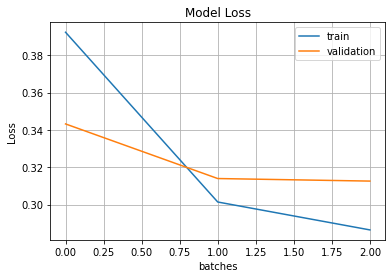

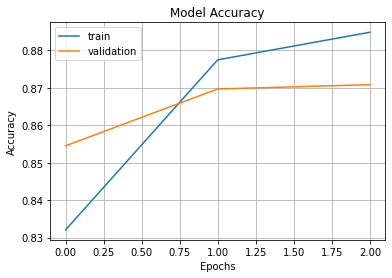

In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: bert-base-uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on ABSTRACT column with 250 token max
fine-tuning enabled, will fine-tune Bert model!
Trainable params: 110.1 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.323921	Acc: 0.869968
  Validation metrics:
	Avg. valid. loss: 0.256780, Acc. multi: 0.893147
	Avg. F1 Score (Micro) = 0.828226, Avg. F1 Score (Macro) = 0.820356

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.227506	Acc: 0.912319
  Validation metrics:
	Avg. valid. loss: 0.239326, Acc. multi: 0.902760
	Avg. F1 Score (Micro) = 0.843590, Avg. F1 Score (Macro) = 0.833942

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.216055	Acc: 0.917585
  Validation metrics:
	Avg. valid. loss: 0.238200, Acc. multi: 0.903046
	Avg. F1 Score (Micro) = 0.844038, Avg. F1 Score (Macro) = 0.834151


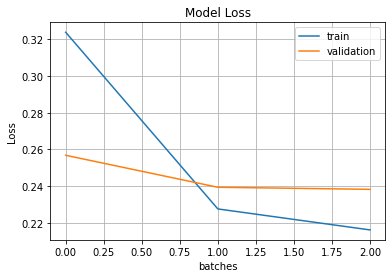

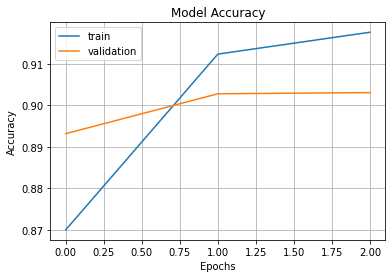

2


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: bert-base-uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on TEXT column with 270 token max
fine-tuning enabled, will fine-tune Bert model!
Trainable params: 110.1 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.318801	Acc: 0.874221
  Validation metrics:
	Avg. valid. loss: 0.247689, Acc. multi: 0.897979
	Avg. F1 Score (Micro) = 0.835380, Avg. F1 Score (Macro) = 0.823428

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.223375	Acc: 0.914073
  Validation metrics:
	Avg. valid. loss: 0.236260, Acc. multi: 0.903349
	Avg. F1 Score (Micro) = 0.845441, Avg. F1 Score (Macro) = 0.836403

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.212718	Acc: 0.918183
  Validation metrics:
	Avg. valid. loss: 0.233962, Acc. multi: 0.904862
	Avg. F1 Score (Micro) = 0.848065, Avg. F1 Score (Macro) = 0.838505


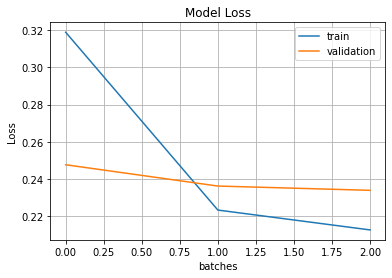

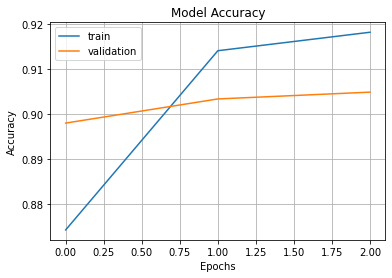

3


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: bert-base-uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on TITLE column with 20 token max
fine-tuning disabled, only training the head!
Trainable params: 0.6 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.593262	Acc: 0.683576
  Validation metrics:
	Avg. valid. loss: 0.525379, Acc. multi: 0.738847
	Avg. F1 Score (Micro) = 0.337980, Avg. F1 Score (Macro) = 0.221207

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.528109	Acc: 0.743892
  Validation metrics:
	Avg. valid. loss: 0.506808, Acc. multi: 0.759550
	Avg. F1 Score (Micro) = 0.427857, Avg. F1 Score (Macro) = 0.327103

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.518454	Acc: 0.755889
  Validation metrics:
	Avg. valid. loss: 0.503421, Acc. multi: 0.763154
	Avg. F1 Score (Micro) = 0.443401, Avg. F1 Score (Macro) = 0.342685


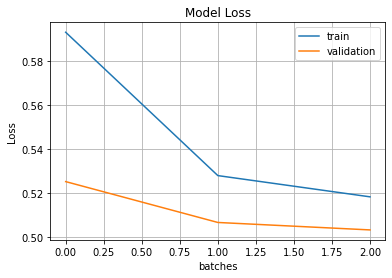

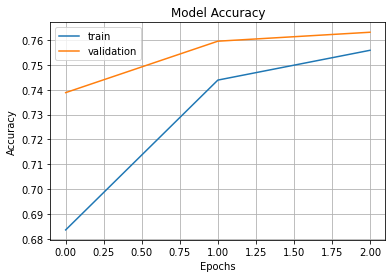

4


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: bert-base-uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on ABSTRACT column with 250 token max
fine-tuning disabled, only training the head!
Trainable params: 0.6 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.565131	Acc: 0.710442
  Validation metrics:
	Avg. valid. loss: 0.479412, Acc. multi: 0.782823
	Avg. F1 Score (Micro) = 0.513659, Avg. F1 Score (Macro) = 0.400661

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.480663	Acc: 0.788953
  Validation metrics:
	Avg. valid. loss: 0.456904, Acc. multi: 0.800289
	Avg. F1 Score (Micro) = 0.578210, Avg. F1 Score (Macro) = 0.469258

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.468499	Acc: 0.798656
  Validation metrics:
	Avg. valid. loss: 0.452910, Acc. multi: 0.802498
	Avg. F1 Score (Micro) = 0.585822, Avg. F1 Score (Macro) = 0.477807


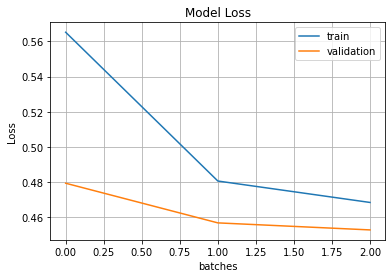

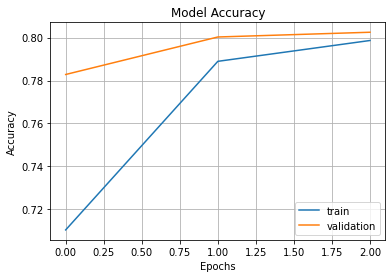

5


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: bert-base-uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on TEXT column with 270 token max
fine-tuning disabled, only training the head!
Trainable params: 0.6 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.560788	Acc: 0.717098
  Validation metrics:
	Avg. valid. loss: 0.475453, Acc. multi: 0.790723
	Avg. F1 Score (Micro) = 0.544868, Avg. F1 Score (Macro) = 0.436719

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.477448	Acc: 0.796224
  Validation metrics:
	Avg. valid. loss: 0.453205, Acc. multi: 0.804876
	Avg. F1 Score (Micro) = 0.593192, Avg. F1 Score (Macro) = 0.487945

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.465178	Acc: 0.804151
  Validation metrics:
	Avg. valid. loss: 0.449294, Acc. multi: 0.807248
	Avg. F1 Score (Micro) = 0.601274, Avg. F1 Score (Macro) = 0.496205


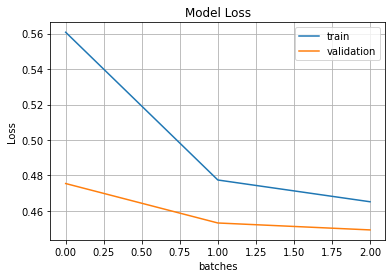

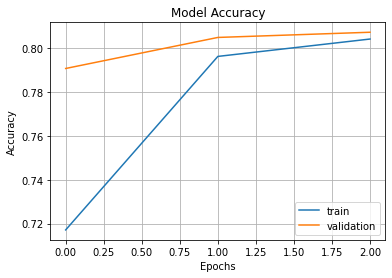

6


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: allenai/scibert_scivocab_uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on TITLE column with 20 token max
fine-tuning enabled, will fine-tune Bert model!
Trainable params: 110.5 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.326715	Acc: 0.862742
  Validation metrics:
	Avg. valid. loss: 0.289458, Acc. multi: 0.877547
	Avg. F1 Score (Micro) = 0.798071, Avg. F1 Score (Macro) = 0.789547

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.245679	Acc: 0.899920
  Validation metrics:
	Avg. valid. loss: 0.268004, Acc. multi: 0.889763
	Avg. F1 Score (Micro) = 0.821924, Avg. F1 Score (Macro) = 0.809536

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.232927	Acc: 0.905051
  Validation metrics:
	Avg. valid. loss: 0.266070, Acc. multi: 0.891119
	Avg. F1 Score (Micro) = 0.824168, Avg. F1 Score (Macro) = 0.811881


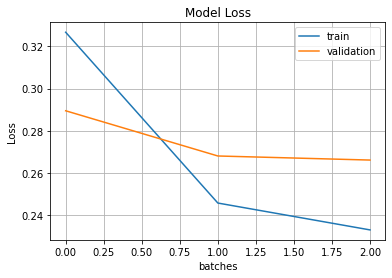

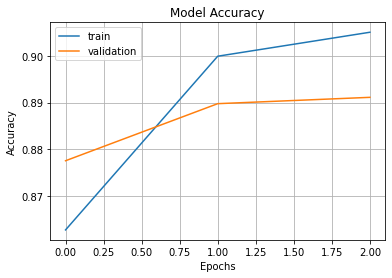

7


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: allenai/scibert_scivocab_uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on ABSTRACT column with 250 token max
fine-tuning enabled, will fine-tune Bert model!
Trainable params: 110.5 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.266275	Acc: 0.894155
  Validation metrics:
	Avg. valid. loss: 0.209761, Acc. multi: 0.914275
	Avg. F1 Score (Micro) = 0.864025, Avg. F1 Score (Macro) = 0.854206

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.188863	Acc: 0.925222
  Validation metrics:
	Avg. valid. loss: 0.204544, Acc. multi: 0.915579
	Avg. F1 Score (Micro) = 0.866342, Avg. F1 Score (Macro) = 0.857779

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.179597	Acc: 0.929752
  Validation metrics:
	Avg. valid. loss: 0.203211, Acc. multi: 0.915778
	Avg. F1 Score (Micro) = 0.866453, Avg. F1 Score (Macro) = 0.857

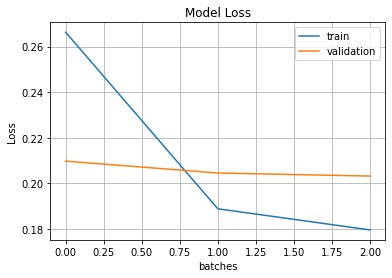

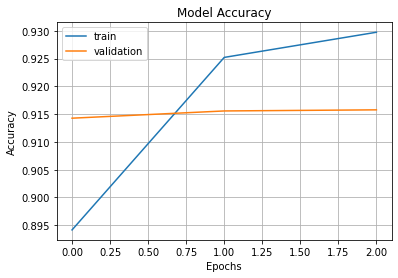

8


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: allenai/scibert_scivocab_uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on TEXT column with 270 token max
fine-tuning enabled, will fine-tune Bert model!
Trainable params: 110.5 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.274937	Acc: 0.889938
  Validation metrics:
	Avg. valid. loss: 0.212002, Acc. multi: 0.913784
	Avg. F1 Score (Micro) = 0.862549, Avg. F1 Score (Macro) = 0.853646

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.190092	Acc: 0.925891
  Validation metrics:
	Avg. valid. loss: 0.204509, Acc. multi: 0.915292
	Avg. F1 Score (Micro) = 0.865933, Avg. F1 Score (Macro) = 0.857530

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.180087	Acc: 0.929513
  Validation metrics:
	Avg. valid. loss: 0.203583, Acc. multi: 0.916069
	Avg. F1 Score (Micro) = 0.867004, Avg. F1 Score (Macro) = 0.859185


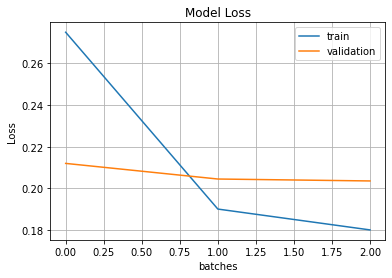

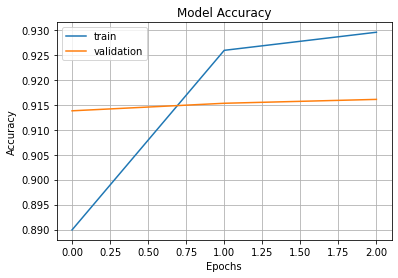

9


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: allenai/scibert_scivocab_uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on TITLE column with 20 token max
fine-tuning disabled, only training the head!
Trainable params: 0.6 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.535958	Acc: 0.744159
  Validation metrics:
	Avg. valid. loss: 0.431589, Acc. multi: 0.819565
	Avg. F1 Score (Micro) = 0.633820, Avg. F1 Score (Macro) = 0.544264

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.443239	Acc: 0.811701
  Validation metrics:
	Avg. valid. loss: 0.407373, Acc. multi: 0.829393
	Avg. F1 Score (Micro) = 0.669137, Avg. F1 Score (Macro) = 0.597886

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.430246	Acc: 0.819155
  Validation metrics:
	Avg. valid. loss: 0.403269, Acc. multi: 0.831275
	Avg. F1 Score (Micro) = 0.675401, Avg. F1 Score (Macro) = 0.607995


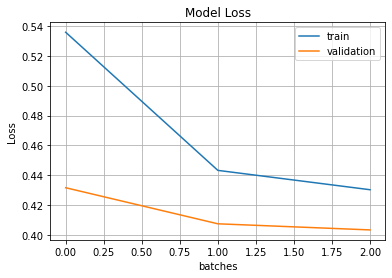

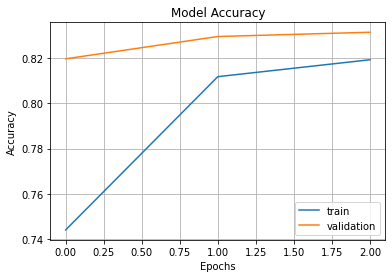

10


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: allenai/scibert_scivocab_uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on ABSTRACT column with 250 token max
fine-tuning disabled, only training the head!
Trainable params: 0.6 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.514626	Acc: 0.760010
  Validation metrics:
	Avg. valid. loss: 0.389830, Acc. multi: 0.838866
	Avg. F1 Score (Micro) = 0.689364, Avg. F1 Score (Macro) = 0.608031

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.393028	Acc: 0.843557
  Validation metrics:
	Avg. valid. loss: 0.364654, Acc. multi: 0.852263
	Avg. F1 Score (Micro) = 0.729797, Avg. F1 Score (Macro) = 0.673950

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.378703	Acc: 0.849284
  Validation metrics:
	Avg. valid. loss: 0.360381, Acc. multi: 0.854227
	Avg. F1 Score (Micro) = 0.735207, Avg. F1 Score (Macro) = 0.683848


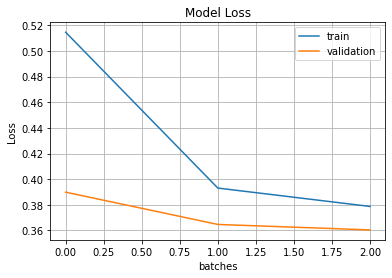

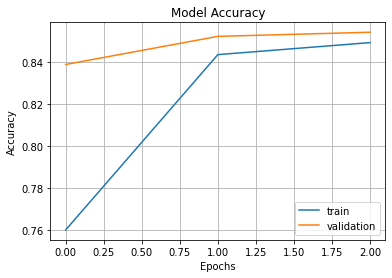

11


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

Device: cuda:0
Bert: allenai/scibert_scivocab_uncased
Original Dataset: (20316, 8)
Training Dataset: (14221, 8)
Validation Dataset: (6095, 8)
Training on TEXT column with 270 token max
fine-tuning disabled, only training the head!
Trainable params: 0.6 M

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.523348	Acc: 0.751198
  Validation metrics:
	Avg. valid. loss: 0.394659, Acc. multi: 0.838433
	Avg. F1 Score (Micro) = 0.692299, Avg. F1 Score (Macro) = 0.612716

Epoch 2 (lr = 2.00e-06)
-------------------------------
  Training metrics:
	Loss: 0.397883	Acc: 0.842578
  Validation metrics:
	Avg. valid. loss: 0.367867, Acc. multi: 0.852269
	Avg. F1 Score (Micro) = 0.729074, Avg. F1 Score (Macro) = 0.677501

Epoch 3 (lr = 4.00e-07)
-------------------------------
  Training metrics:
	Loss: 0.382913	Acc: 0.848126
  Validation metrics:
	Avg. valid. loss: 0.363322, Acc. multi: 0.854636
	Avg. F1 Score (Micro) = 0.735647, Avg. F1 Score (Macro) = 0.687637


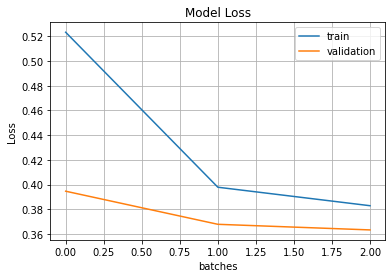

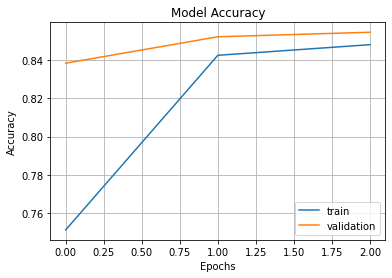

12


In [ ]:
train_model(df, fine_tuning = bools_berts[index][0],  bert_model = bools_berts[index][1], column = bools_berts[index][2][0], max_len = bools_berts[index][2][1])
index+=1
print(index)

# Granular topic predictions for Statistics and Computer Science

In [ ]:
granular_path = '/content/drive/MyDrive/NLP_Final_Project'

In [ ]:
cs_df = pd.read_csv(granular_path + '/FINAL2_cs_subjects.csv')
# remove labels with less than 100 clssifications
columns_to_save = (cs_df.iloc[:,2:].sum(axis = 0) > 250).tolist()
columns_to_drop = cs_df.iloc[:,2:].columns[np.invert(columns_to_save)]
cs_df = cs_df.drop(columns = columns_to_drop)

# remove rows that have no label
cs_df = cs_df[cs_df.iloc[:,2:].sum(axis = 1) > 0].reset_index(drop=True)
cs_df['labels'] = cs_df.iloc[:,2:].values.tolist()
cs_df['TEXT'] = pd.Series([" ".join(sentence.split(" ")[:20]) for sentence in cs_df['TITLE']]) + " " + cs_df['ABSTRACT']
cs_df.head()

,TITLE,ABSTRACT,cs.AI,cs.CL,cs.CR,cs.CV,cs.DS,cs.IT,cs.LG,cs.LO,cs.RO,cs.SI,cs.SY,labels,TEXT
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",Reconstructing Subject-Specific Effect Maps ...
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",Rotation Invariance Neural Network Rotation ...
2,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",Comparative study of Discrete Wavelet Transfor...
3,Fault Detection and Isolation Tools (FDITOOLS)...,The Fault Detection and Isolation Tools (FDI...,0,0,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",Fault Detection and Isolation Tools (FDITOOLS)...
4,Complexity of Deciding Detectability in Discre...,Detectability of discrete event systems (DES...,0,0,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",Complexity of Deciding Detectability in Discre...


In [ ]:
cs_df.iloc[:,2:-2].sample(frac=0.075).sum(axis=0)

cs.AI     63
cs.CL     36
cs.CR     17
cs.CV     63
cs.DS     35
cs.IT     44
cs.LG    166
cs.LO     20
cs.RO     44
cs.SI     52
cs.SY     32
dtype: int64

In [ ]:
stat_df = pd.read_csv(granular_path + '/FINAL_stat_sharon.csv')
# remove labels with less than 100 clssifications
columns_to_save = (stat_df.iloc[:,2:].sum(axis = 0) > 250).tolist()
columns_to_drop = stat_df.iloc[:,2:].columns[np.invert(columns_to_save)]
stat_df = stat_df.drop(columns = columns_to_drop)

# remove rows that have no label
stat_df = stat_df[stat_df.iloc[:,2:].sum(axis = 1) > 0].reset_index(drop=True)
stat_df['labels'] = stat_df.iloc[:,2:].values.tolist()
stat_df['TEXT'] = pd.Series([" ".join(sentence.split(" ")[:20]) for sentence in stat_df['TITLE']]) + " " + stat_df['ABSTRACT']
stat_df.head()

,TITLE,ABSTRACT,stat.AP,stat.CO,stat.ME,stat.ML,stat.TH,labels,TEXT
0,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,0,0,0,1,0,"[0, 0, 0, 1, 0]",Comparative study of Discrete Wavelet Transfor...
1,Comparing Covariate Prioritization via Matchin...,When investigators seek to estimate causal e...,1,0,0,0,0,"[1, 0, 0, 0, 0]",Comparing Covariate Prioritization via Matchin...
2,"Covariances, Robustness, and Variational Bayes",Mean-field Variational Bayes (MFVB) is an ap...,0,0,1,0,0,"[0, 0, 1, 0, 0]","Covariances, Robustness, and Variational Bayes..."
3,Large Scale Automated Forecasting for Monitori...,Real time large scale streaming data pose ma...,1,1,0,1,0,"[1, 1, 0, 1, 0]",Large Scale Automated Forecasting for Monitori...
4,Contextual Regression: An Accurate and Conveni...,Machine learning algorithms such as linear r...,1,1,0,1,0,"[1, 1, 0, 1, 0]",Contextual Regression: An Accurate and Conveni...


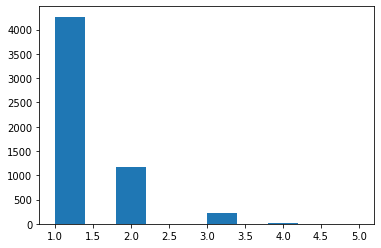

In [ ]:
cs_subject_df = cs_df.drop(columns = ['TITLE', 'ABSTRACT', 'TEXT','labels'])

subject_per_entry = cs_subject_df.sum(axis=1)
subject_per_entry.hist(grid=False)
plt.show()

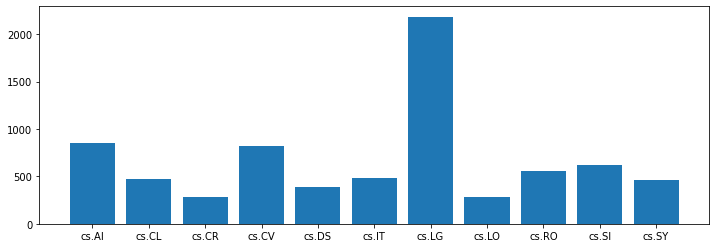

In [ ]:
cs_column_names = cs_subject_df.columns
X_axis = range(len(cs_column_names))

plt.figure(figsize=(12, 4))
plt.bar(X_axis, cs_df.drop(columns = ['TITLE', 'ABSTRACT', 'TEXT','labels'], axis=1).sum())
plt.xticks(X_axis, cs_column_names)

plt.show()

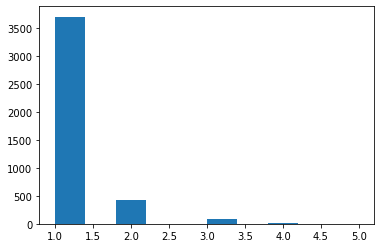

In [ ]:
stat_subject_df = stat_df.drop(columns = ['TITLE', 'ABSTRACT', 'TEXT','labels'])

subject_per_entry = stat_subject_df.sum(axis=1)
subject_per_entry.hist(grid=False)
plt.show()

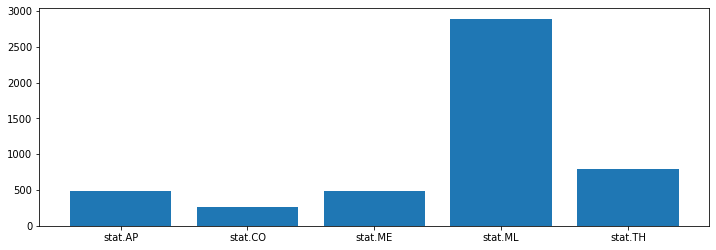

In [ ]:
stat_column_names = stat_subject_df.columns
X_axis = range(len(stat_column_names))

plt.figure(figsize=(12, 4))
plt.bar(X_axis, stat_df.drop(columns = ['TITLE', 'ABSTRACT', 'TEXT','labels'], axis=1).sum())
plt.xticks(X_axis, stat_column_names)

plt.show()

In [ ]:
cs_df['labels'] = cs_df[cs_column_names].values.tolist()
cs_df = cs_df[['TITLE', 'ABSTRACT', 'TEXT', 'labels']]
cs_df

,TITLE,ABSTRACT,TEXT,labels
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,Reconstructing Subject-Specific Effect Maps ...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,Rotation Invariance Neural Network Rotation ...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,Comparative study of Discrete Wavelet Transfor...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,Fault Detection and Isolation Tools (FDITOOLS)...,The Fault Detection and Isolation Tools (FDI...,Fault Detection and Isolation Tools (FDITOOLS)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,Complexity of Deciding Detectability in Discre...,Detectability of discrete event systems (DES...,Complexity of Deciding Detectability in Discre...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...
5684,Do Neural Nets Learn Statistical Laws behind N...,The performance of deep learning in natural ...,Do Neural Nets Learn Statistical Laws behind N...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5685,Faithful Inversion of Generative Models for Ef...,Inference amortization methods share informa...,Faithful Inversion of Generative Models for Ef...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
5686,A social Network Analysis of the Operations Re...,We study the U.S. Operations Research/Indust...,A social Network Analysis of the Operations Re...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
5687,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,Contemporary machine learning: a guide for pra...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


Device: cuda:0
Bert: allenai/scibert_scivocab_uncased
Original Dataset: (5689, 15)
Training Dataset: (3982, 15)
Validation Dataset: (1024, 15)
Test Dataset: (683, 15)
Training on TEXT column with 270 token max
num_classes=11
fine-tuning enabled, will fine-tune Bert model!
Trainable params: 110.5 M
tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 1,  ..., 0, 0, 0]])
num_positives=tensor([ 602,  330,  196,  572,  280,  342, 1551,  190,  389,  437,  326])
num_negatives=tensor([3380, 3652, 3786, 3410, 3702, 3640, 2431, 3792, 3593, 3545, 3656])
pos_weight=tensor([ 5.6146, 11.0667, 19.3163,  5.9615, 13.2214, 10.6433,  1.5674, 19.9579,
         9.2365,  8.1121, 11.2147], device='cuda:0')

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.832681	Acc: 0.773490
  Validation metrics:
	Avg. valid. loss: 0.546147, Acc

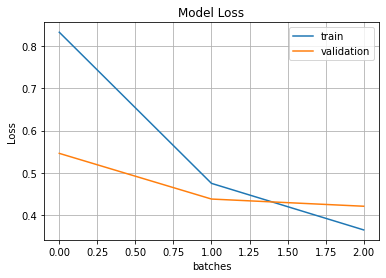

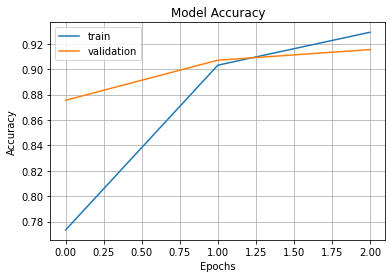

In [ ]:
cs_pred,cs_target=train_model(cs_df, fine_tuning = True,  bert_model = 'scibert', column = 'TEXT', max_len = 270, num_classes=11)

Confusion matrix for label cs.AI:


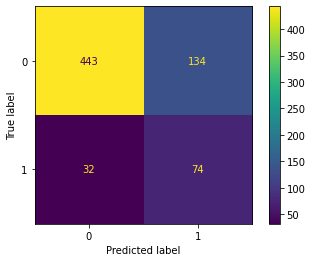

Confusion matrix for label cs.CL:


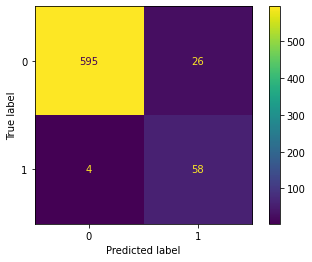

Confusion matrix for label cs.CR:


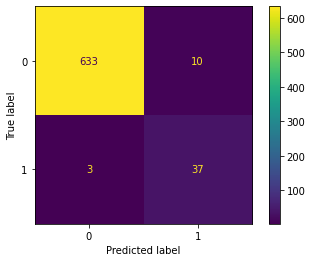

Confusion matrix for label cs.CV:


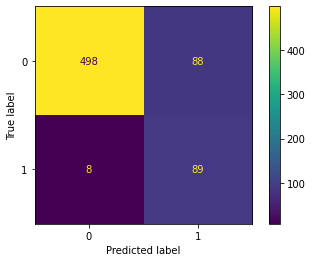

Confusion matrix for label cs.DS:


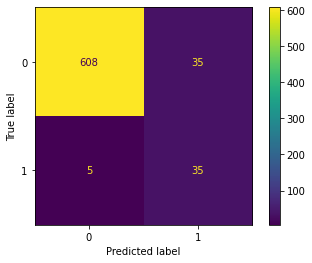

Confusion matrix for label cs.IT:


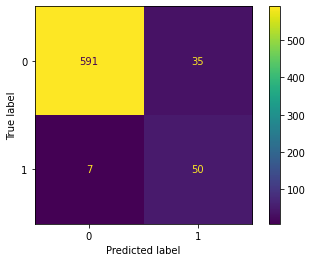

Confusion matrix for label cs.LG:


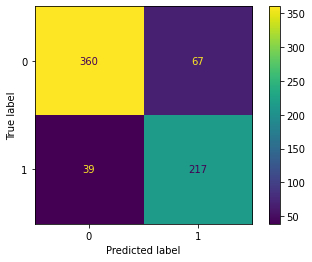

Confusion matrix for label cs.LO:


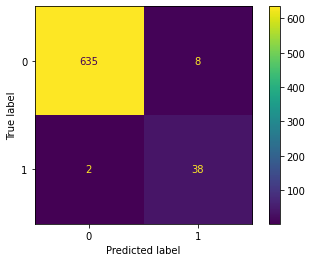

Confusion matrix for label cs.RO:


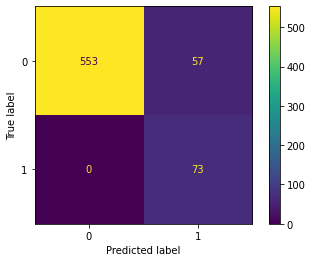

Confusion matrix for label cs.SI:


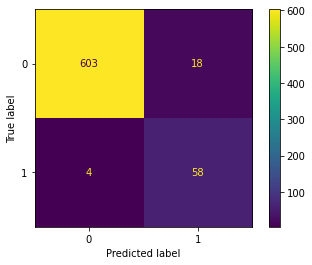

Confusion matrix for label cs.SY:


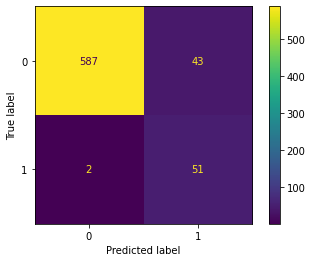

In [ ]:
y_true = cs_target.cpu().detach()
y_pred = cs_pred.cpu().detach()

conf_mat_dict={}

for label_col in range(len(cs_column_names.tolist())):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[cs_column_names.tolist()[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    plt.show()

In [ ]:
y_true = cs_target.cpu().detach()
y_pred = cs_pred.cpu().detach()

print(classification_report(y_true, y_pred, target_names=cs_column_names))

              precision    recall  f1-score   support

       cs.AI       0.36      0.70      0.47       106
       cs.CL       0.69      0.94      0.79        62
       cs.CR       0.79      0.93      0.85        40
       cs.CV       0.50      0.92      0.65        97
       cs.DS       0.50      0.88      0.64        40
       cs.IT       0.59      0.88      0.70        57
       cs.LG       0.76      0.85      0.80       256
       cs.LO       0.83      0.95      0.88        40
       cs.RO       0.56      1.00      0.72        73
       cs.SI       0.76      0.94      0.84        62
       cs.SY       0.54      0.96      0.69        53

   micro avg       0.60      0.88      0.71       886
   macro avg       0.63      0.90      0.73       886
weighted avg       0.63      0.88      0.73       886
 samples avg       0.66      0.91      0.73       886



Device: cuda:0
Bert: allenai/scibert_scivocab_uncased
Original Dataset: (4238, 9)
Training Dataset: (2967, 9)
Validation Dataset: (763, 9)
Test Dataset: (508, 9)
Training on TEXT column with 270 token max
num_classes=5
fine-tuning enabled, will fine-tune Bert model!
Trainable params: 110.5 M
tensor([[0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]])
num_positives=tensor([ 323,  194,  338, 2043,  549])
num_negatives=tensor([2644, 2773, 2629,  924, 2418])
pos_weight=tensor([ 8.1858, 14.2938,  7.7781,  0.4523,  4.4044], device='cuda:0')

Epoch 1 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.821827	Acc: 0.728303
  Validation metrics:
	Avg. valid. loss: 0.658283, Acc. multi: 0.815246
	Avg. F1 Score (Micro) = 0.682846, Avg. F1 Score (Macro) = 0.541414

Epoch 2 (lr = 1.00e-05)
-------------------------------
  Training metrics:
	Loss: 0.589150	Acc: 0.831961
 

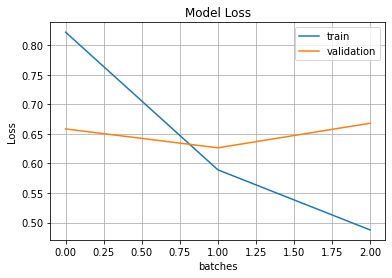

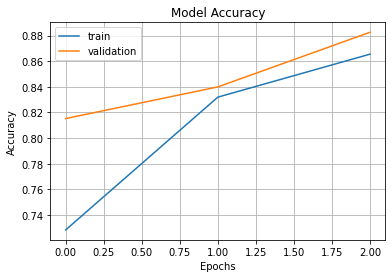

In [ ]:
stat_pred, stat_target = train_model(stat_df, fine_tuning = True,  bert_model = 'scibert', column = 'TEXT', max_len = 270, num_classes=5, epochs = 3)

In [ ]:
y_true = stat_target.cpu().detach()
y_pred = stat_pred.cpu().detach()

print(classification_report(y_true, y_pred, target_names=stat_column_names))

              precision    recall  f1-score   support

     stat.AP       0.65      0.74      0.69        69
     stat.CO       0.26      0.52      0.35        21
     stat.ME       0.38      0.82      0.52        55
     stat.ML       0.91      0.94      0.92       325
     stat.TH       0.63      0.81      0.71       102

   micro avg       0.70      0.87      0.77       572
   macro avg       0.56      0.77      0.64       572
weighted avg       0.75      0.87      0.80       572
 samples avg       0.80      0.89      0.82       572



Confusion matrix for label stat.AP:


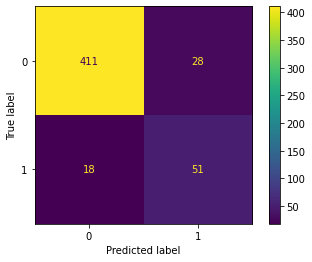

Confusion matrix for label stat.CO:


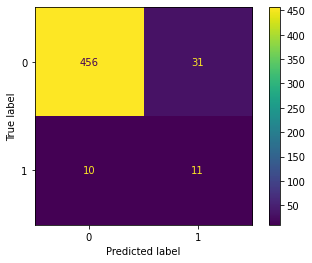

Confusion matrix for label stat.ME:


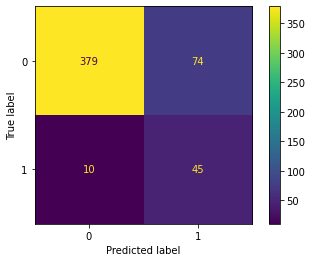

Confusion matrix for label stat.ML:


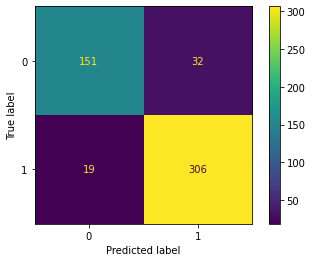

Confusion matrix for label stat.TH:


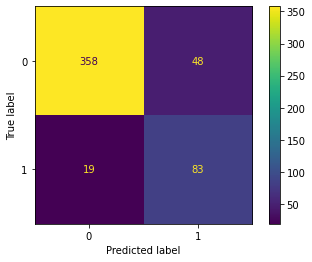

In [ ]:
conf_mat_dict={}

for label_col in range(len(stat_column_names.tolist())):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[stat_column_names.tolist()[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    plt.show()